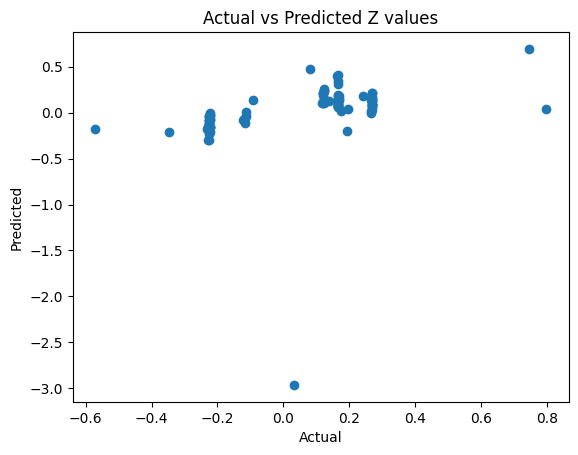

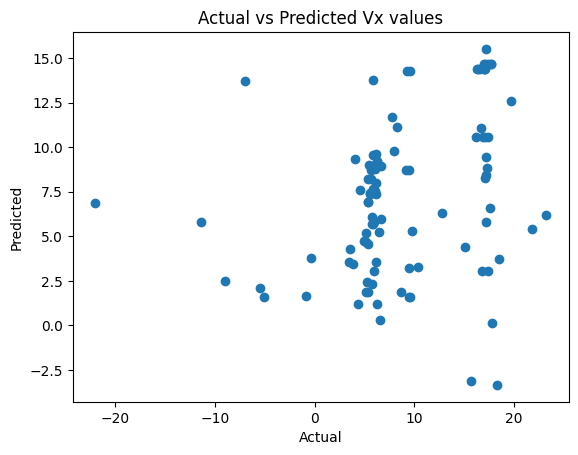

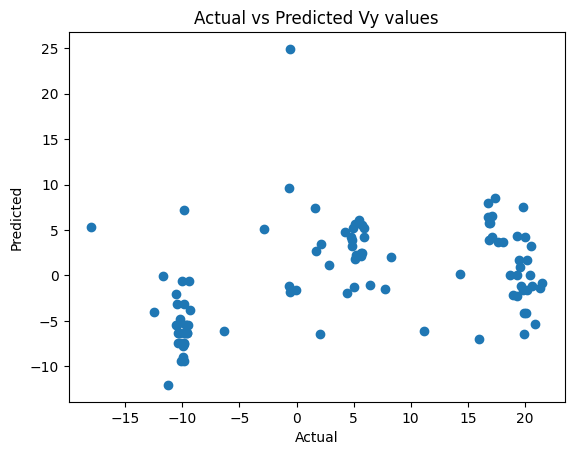

In [2]:
import sqlite3
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from stellarutil import graph
# Step 1: Connect to the SQLite database and retrieve the data
conn = sqlite3.connect('star_data.db')  # Replace with your database name
cursor = conn.cursor()
cursor.execute("SELECT x, y, z, vx, vy, vz, a, r FROM stars WHERE id > 100;")
data = cursor.fetchall()


# Step 2: Prepare the data for training
X = [(x, y, vz, a, r) for x, y, _, _, _, vz, a, r in data]
y = [(z, vx, vy) for _, _, z, vx, vy, _, _, _ in data]
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 4: Initialize and train the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

# Step 5 - Get the test data
cursor.execute("SELECT x, y, z, vx, vy, vz, a, r FROM stars WHERE id < 101;")
test_data = cursor.fetchall()

# Step 6 - create lists to later graph 
actual_values_z = []
predicted_values_z = []
actual_values_vx = []
predicted_values_vx = []
actual_values_vy = []
predicted_values_vy = []

# Step 7 - Make the predictions
for d in test_data:
    # Remove the outlier for a zoomed in graph
    if abs(d[2]) < 1:
        actual_values_z.append(d[2])
        actual_values_vx.append(d[3])
        actual_values_vy.append(d[4])
        new_data_point = [(d[0], d[1], d[5], d[6], d[7])]
        predicted_value = knn_regressor.predict(new_data_point)
        predicted_values_z.append(predicted_value[0][0])
        predicted_values_vx.append(predicted_value[0][1])
        predicted_values_vy.append(predicted_value[0][2])

# Step 8 - Graph
graph.graph(actual_values_z, predicted_values_z, "Actual vs Predicted Z values", "Actual", "Predicted", showLine=False)
graph.graph(actual_values_vx, predicted_values_vx, "Actual vs Predicted Vx values", "Actual", "Predicted", showLine=False)
graph.graph(actual_values_vy, predicted_values_vy, "Actual vs Predicted Vy values", "Actual", "Predicted", showLine=False)

conn.close()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from stellarutil.simulation import Simulation
from stellarutil.graph import graph
from stellarutil.calculations import filter_list, dist
import numpy as np

# Step 1: Get the halo at index 0
m10r = Simulation('m10r_res250md', simulation_directory='../../data')
halo = m10r.get_halo()

# Step 2: Prepare the data for training
X = []
y = []
for star in halo.stars:
    X.append([star.x, star.y, star.vz, star.a, star.get2DR()])
    y.append(get_dm_mass(star))

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and train the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

# Step 5: Predict on the test data
y_pred = knn_regressor.predict(X_test)

# Step 6 - graph
fig = graph(y_test, y_pred, "Actual vs Predicted DM mass", "Actual", "Predicted", showLine=False, logx=True, logy=True)
fig.plot([0, 1], [0, 1], label='y = x', linestyle='--', color='red')